In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
import ffn
from math import floor
from termcolor import colored as cl
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [2]:
def get_historical_data(symbol, start_date = None):
    api_key = open(r'api_key.txt')
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('IBM', '2019-01-01')
ibm

,open,high,low,close,adj close,volume
2019-01-02,112.01,115.98,111.69,115.21,88.214335,4239924.0
2019-01-03,114.53,114.88,112.69,112.91,86.453264,4346659.0
2019-01-04,114.91,117.49,114.44,117.32,89.829926,4477755.0
2019-01-07,117.50,118.83,116.67,118.15,90.465443,3751204.0
2019-01-08,119.66,120.57,118.98,119.83,91.751790,4763636.0
...,...,...,...,...,...,...
2023-05-22,127.50,128.19,127.15,127.50,127.500000,2806770.0
2023-05-23,127.24,129.09,127.13,128.18,128.180000,4592280.0
2023-05-24,127.82,127.90,125.47,125.68,125.680000,3915505.0
2023-05-25,125.61,127.23,125.01,126.76,126.760000,4102854.0


In [3]:
ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1109 entries, 2019-01-02 to 2023-05-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1109 non-null   float64
 1   high       1109 non-null   float64
 2   low        1109 non-null   float64
 3   close      1109 non-null   float64
 4   adj close  1109 non-null   float64
 5   volume     1109 non-null   float64
dtypes: float64(6)
memory usage: 60.6 KB


In [4]:
ibm.describe()

,open,high,low,close,adj close,volume
count,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1.109000e+03
mean,132.098907,133.300434,130.907588,132.128251,114.901121,4.907375e+06
std,9.560265,9.395617,9.697514,9.556362,12.433519,3.055598e+06
min,94.600000,97.740000,90.560000,94.770000,76.844326,1.202087e+06
25%,124.900000,126.030000,123.820000,124.920000,105.633699,3.268738e+06
50%,133.280000,134.385000,132.140000,133.220000,113.397798,4.185254e+06
75%,139.460000,140.440000,138.520000,139.430000,124.454996,5.447948e+06
max,156.820000,158.750000,155.420000,156.760000,146.725039,3.806353e+07


In [5]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
ibm

,open,high,low,close,adj close,volume,rsi_14
2019-01-08,119.66,120.57,118.98,119.83,91.751790,4763636.0,77.250503
2019-01-09,120.91,121.40,119.87,120.69,92.410277,3633663.0,79.586145
2019-01-10,120.08,121.86,119.95,121.79,93.252529,3909971.0,82.115399
2019-01-11,121.58,121.62,120.20,121.46,92.999853,3722370.0,78.954922
2019-01-14,120.51,120.65,119.76,120.39,92.180573,5228909.0,69.600918
...,...,...,...,...,...,...,...
2023-05-22,127.50,128.19,127.15,127.50,127.500000,2806770.0,58.849015
2023-05-23,127.24,129.09,127.13,128.18,128.180000,4592280.0,61.090390
2023-05-24,127.82,127.90,125.47,125.68,125.680000,3915505.0,50.253261
2023-05-25,125.61,127.23,125.01,126.76,126.760000,4102854.0,54.045840


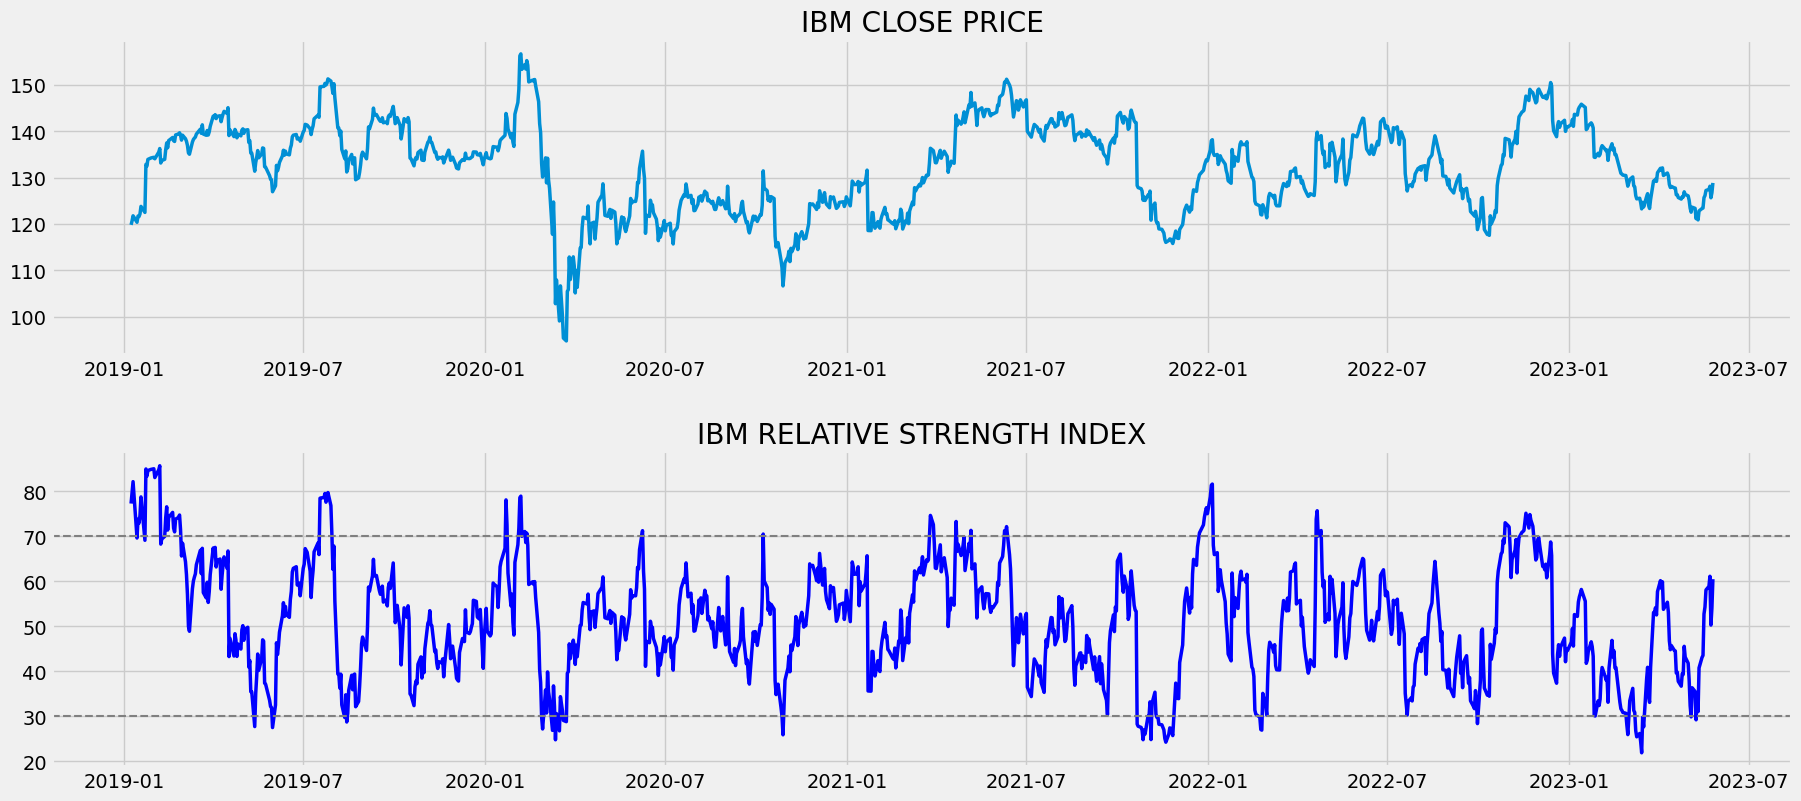

In [6]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('IBM CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'blue', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('IBM RELATIVE STRENGTH INDEX')
plt.show()

In [7]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

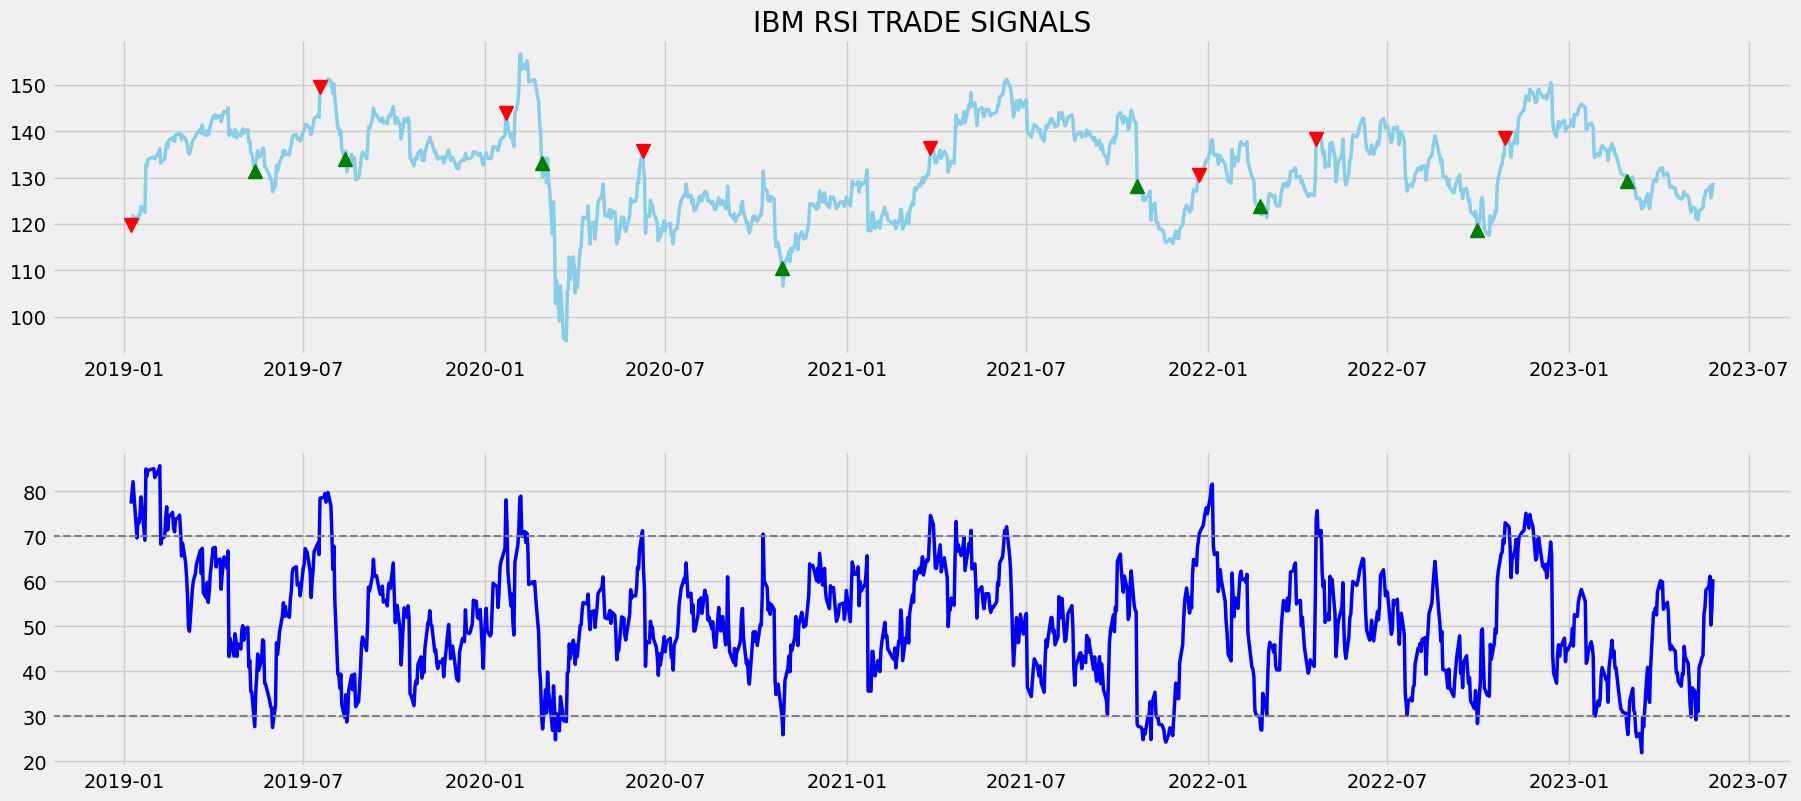

In [8]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('IBM RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'blue', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [9]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
2019-01-08,119.83,77.250503,-1,0
2019-01-09,120.69,79.586145,0,0
2019-01-10,121.79,82.115399,0,0
2019-01-11,121.46,78.954922,0,0
2019-01-14,120.39,69.600918,0,0


In [10]:
strategy['daily_return'] = strategy['close'].diff()

In [11]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return
2019-01-08,119.83,77.250503,-1,0,NaN
2019-01-09,120.69,79.586145,0,0,0.86
2019-01-10,121.79,82.115399,0,0,1.10
2019-01-11,121.46,78.954922,0,0,-0.33
2019-01-14,120.39,69.600918,0,0,-1.07
...,...,...,...,...,...
2023-05-22,127.50,58.849015,0,1,0.24
2023-05-23,128.18,61.090390,0,1,0.68
2023-05-24,125.68,50.253261,0,1,-2.50
2023-05-25,126.76,54.045840,0,1,1.08


In [12]:
strategy['rsi_strategy_ret'] = np.nan
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret
2019-01-08,119.83,77.250503,-1,0,NaN,NaN
2019-01-09,120.69,79.586145,0,0,0.86,NaN
2019-01-10,121.79,82.115399,0,0,1.10,NaN
2019-01-11,121.46,78.954922,0,0,-0.33,NaN
2019-01-14,120.39,69.600918,0,0,-1.07,NaN
...,...,...,...,...,...,...
2023-05-22,127.50,58.849015,0,1,0.24,NaN
2023-05-23,128.18,61.090390,0,1,0.68,NaN
2023-05-24,125.68,50.253261,0,1,-2.50,NaN
2023-05-25,126.76,54.045840,0,1,1.08,NaN


In [13]:

for i in range(1,len(strategy)):
    strategy['rsi_strategy_ret'][i] = strategy['daily_return'][i]*strategy['rsi_position'][i-1]

C:\Users\hp\AppData\Local\Temp\ipykernel_10268\3129954452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy['rsi_strategy_ret'][i] = strategy['daily_return'][i]*strategy['rsi_position'][i-1]


In [14]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret
2019-01-08,119.83,77.250503,-1,0,NaN,NaN
2019-01-09,120.69,79.586145,0,0,0.86,0.00
2019-01-10,121.79,82.115399,0,0,1.10,0.00
2019-01-11,121.46,78.954922,0,0,-0.33,-0.00
2019-01-14,120.39,69.600918,0,0,-1.07,-0.00
...,...,...,...,...,...,...
2023-05-22,127.50,58.849015,0,1,0.24,0.24
2023-05-23,128.18,61.090390,0,1,0.68,0.68
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50
2023-05-25,126.76,54.045840,0,1,1.08,1.08


In [15]:
strategy['cumm_rsi_strategy_ret'] = strategy['rsi_strategy_ret'].cumsum()

In [16]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret
2019-01-08,119.83,77.250503,-1,0,NaN,NaN,NaN
2019-01-09,120.69,79.586145,0,0,0.86,0.00,0.00
2019-01-10,121.79,82.115399,0,0,1.10,0.00,0.00
2019-01-11,121.46,78.954922,0,0,-0.33,-0.00,0.00
2019-01-14,120.39,69.600918,0,0,-1.07,-0.00,0.00
...,...,...,...,...,...,...,...
2023-05-22,127.50,58.849015,0,1,0.24,0.24,91.04
2023-05-23,128.18,61.090390,0,1,0.68,0.68,91.72
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,89.22
2023-05-25,126.76,54.045840,0,1,1.08,1.08,90.30


In [17]:
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])

strategy['rsi_investment_ret'] = np.nan

for i in range(len(strategy)):
    strategy['rsi_investment_ret'][i] = number_of_stocks*strategy['rsi_strategy_ret'][i]

C:\Users\hp\AppData\Local\Temp\ipykernel_10268\1878470567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy['rsi_investment_ret'][i] = number_of_stocks*strategy['rsi_strategy_ret'][i]


In [18]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret,rsi_investment_ret
2019-01-08,119.83,77.250503,-1,0,NaN,NaN,NaN,NaN
2019-01-09,120.69,79.586145,0,0,0.86,0.00,0.00,0.00
2019-01-10,121.79,82.115399,0,0,1.10,0.00,0.00,0.00
2019-01-11,121.46,78.954922,0,0,-0.33,-0.00,0.00,-0.00
2019-01-14,120.39,69.600918,0,0,-1.07,-0.00,0.00,-0.00
...,...,...,...,...,...,...,...,...
2023-05-22,127.50,58.849015,0,1,0.24,0.24,91.04,186.00
2023-05-23,128.18,61.090390,0,1,0.68,0.68,91.72,527.00
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,89.22,-1937.50
2023-05-25,126.76,54.045840,0,1,1.08,1.08,90.30,837.00


In [19]:
strategy['cum_rsi_investment_ret'] = strategy['rsi_investment_ret'].cumsum()

In [20]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret,rsi_investment_ret,cum_rsi_investment_ret
2019-01-08,119.83,77.250503,-1,0,NaN,NaN,NaN,NaN,NaN
2019-01-09,120.69,79.586145,0,0,0.86,0.00,0.00,0.00,0.00
2019-01-10,121.79,82.115399,0,0,1.10,0.00,0.00,0.00,0.00
2019-01-11,121.46,78.954922,0,0,-0.33,-0.00,0.00,-0.00,0.00
2019-01-14,120.39,69.600918,0,0,-1.07,-0.00,0.00,-0.00,0.00
...,...,...,...,...,...,...,...,...,...
2023-05-22,127.50,58.849015,0,1,0.24,0.24,91.04,186.00,70556.00
2023-05-23,128.18,61.090390,0,1,0.68,0.68,91.72,527.00,71083.00
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,89.22,-1937.50,69145.50
2023-05-25,126.76,54.045840,0,1,1.08,1.08,90.30,837.00,69982.50


In [21]:
stats = strategy['cum_rsi_investment_ret'].calc_stats()
stats.display()

Stats for cum_rsi_investment_ret from 2019-01-08 00:00:00 - 2023-05-26 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
-               -         inf%    -188.07%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y      5y    10y    incep.
-----  ------  ------  ------  ------  ------  ----  -----  --------
2.76%  -0.44%  -0.44%  -0.44%  26.37%  77.21%  inf%  -      inf%

Periodic:
        daily     monthly    yearly
------  --------  ---------  --------
sharpe  -         -          0.89
mean    inf%      -inf%      59.72%
vol     -         -          66.86%
skew    -         -          1.28
kurt    -         -          1.70
best    inf%      252.24%    153.39%
worst   -314.54%  -inf%      -0.44%

Drawdowns:
max       avg        # days
--------  -------  --------
-188.07%  -18.23%     23.73

Misc:
---------------  ------
avg. up month    46.07%
avg. down month  -inf%
up y

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:1376: RuntimeWarning: divide by zero encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:325: RuntimeWarning: invalid value encountered in double_scalars
  self.return_table[fidx.year][fidx.month] = float(mp[0]) / dp[0] - 1
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  if mp[i] / mp[i - 11] > 1:
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:1376: RuntimeWarning: divide by zero encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1


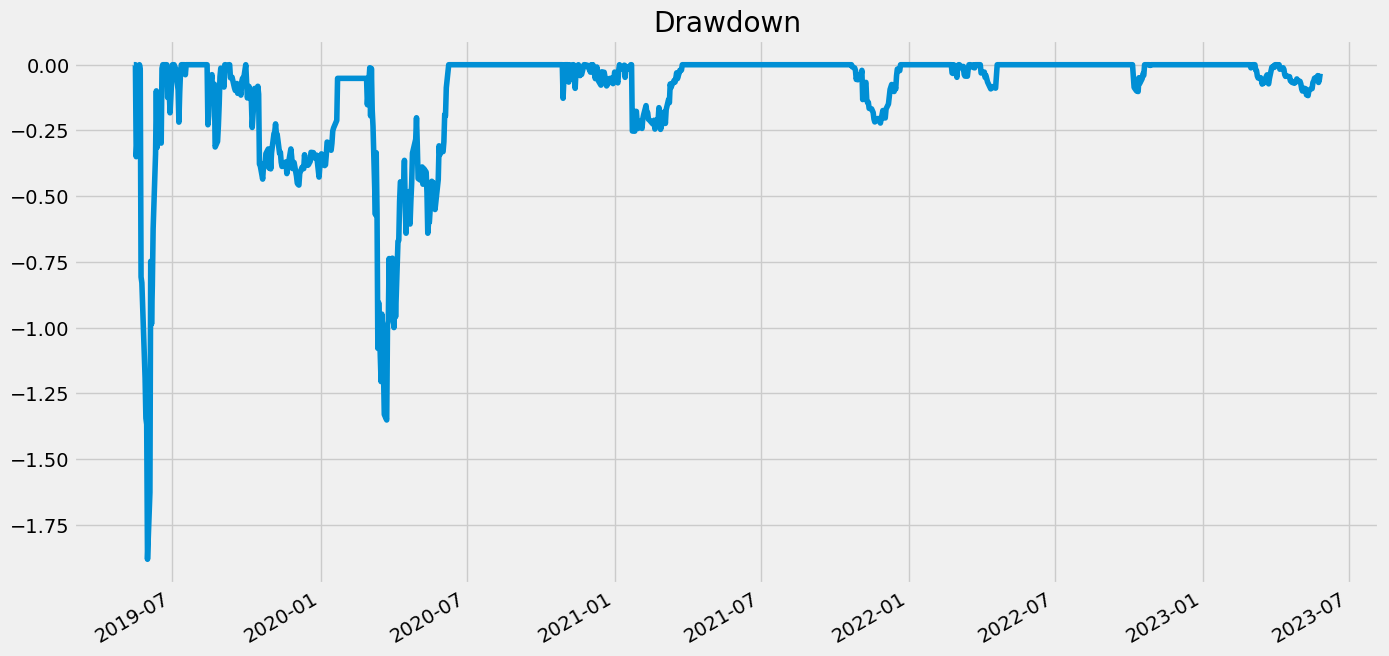

In [22]:
ax = stats.prices.to_drawdown_series().plot(figsize=(15, 8),title='Drawdown')

<AxesSubplot:title={'center':'cum_rsi_investment_ret Price Series'}>

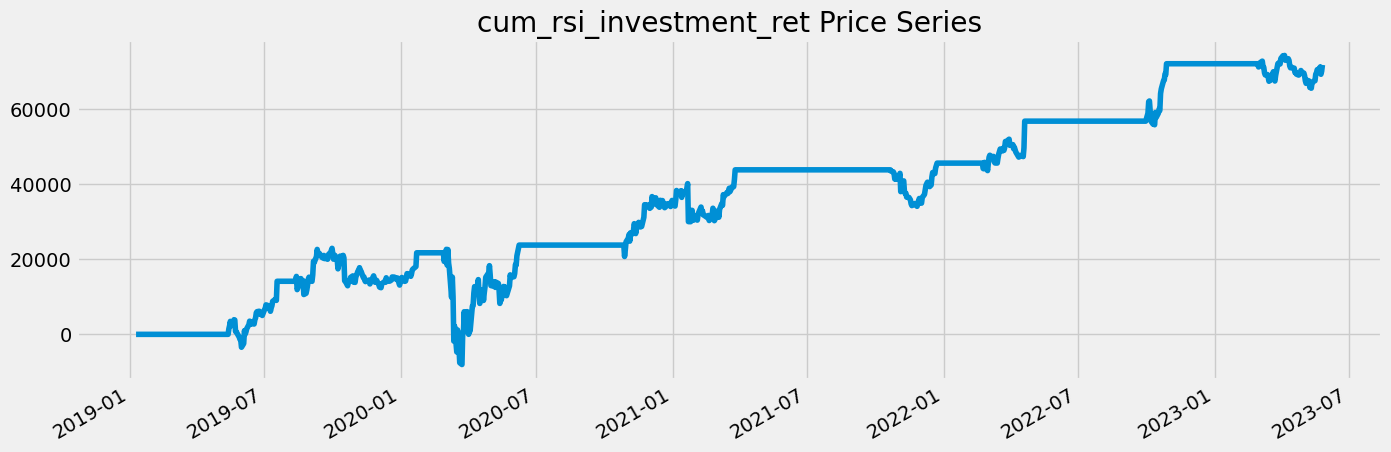

In [23]:
stats.plot()